# Temp Analysis

In [398]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [399]:
sns.set_theme()

In [400]:
TEMP_GLOBAL_FILE = 'data/processed/temperature/temp-land-ocean-global.csv'
TEMP_REGION_FILE = 'data/processed/temperature/temp-land-region.csv'
TEMP_COUNTRY_FILE = 'data/processed/temperature/temp-land-country.csv'
DIS_ALL_FILE = 'data/processed/disaster/disaster-all.csv'

In [401]:
# Todo: replace when merging
temp_global = pd.read_csv(TEMP_GLOBAL_FILE)
temp_region = pd.read_csv(TEMP_REGION_FILE)
temp_country = pd.read_csv(TEMP_COUNTRY_FILE)
dis_all = pd.read_csv(DIS_ALL_FILE)

## Add smoothing

We apply lowess smoothing to the temperature anomaly data and add it to our datasets.

In [402]:
# applies lowess smoothing to each group
# if no group is supplied lowess will be applied to the whole dataset
def lowess_grouped(data: pd.DataFrame, x_name: str, y_name: str, group_name, frac: float):
    df = data.copy()
    y_name_smoothed = y_name + "_smooth"
    if group_name is not None:
        groups = df[group_name].unique().tolist()
        smoothed_dfs = []
        for group in groups:
            df_by_select_group = df[df[group_name] == group]
            smoothed_df = sm.nonparametric.lowess(df_by_select_group[y_name],df_by_select_group[x_name],frac=frac)
            smoothed_df = pd.DataFrame(smoothed_df)
            smoothed_df.columns = [x_name, y_name_smoothed]
            smoothed_df[x_name] = smoothed_df[x_name].astype(int)
            smoothed_df[group_name] = group
            smoothed_dfs.append(smoothed_df)
        return pd.merge(df,pd.concat(smoothed_dfs), how="left", on=[x_name,group_name])
    else:
        smoothed_df = sm.nonparametric.lowess(df[y_name], df[x_name], frac=frac)
        smoothed_df = pd.DataFrame(smoothed_df)
        smoothed_df.columns = [x_name, y_name_smoothed]
        return pd.merge(df,smoothed_df, how="left", on=x_name)

In [403]:
temp_global = lowess_grouped(temp_global, "year", "temperature_anomaly", None, frac=0.05)
temp_region = lowess_grouped(temp_region, "year", "temperature_anomaly", "region_name", frac=0.05)
temp_country = lowess_grouped(temp_country, "year", "temperature_anomaly", "country_name", frac=0.05)

## Global temperature trend

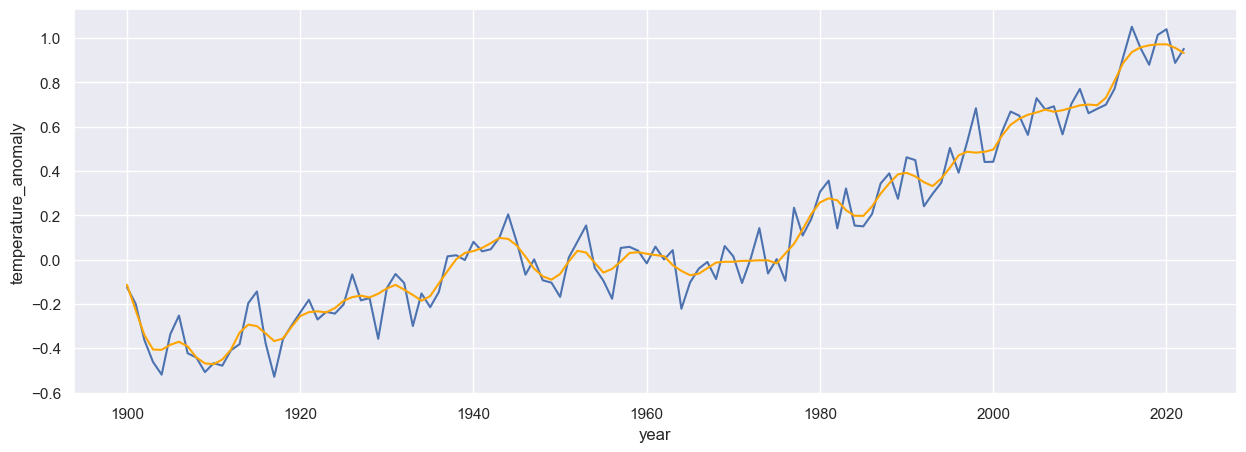

In [404]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly", data=temp_global)
sns.lineplot(x="year", y="temperature_anomaly_smooth", data=temp_global, color="orange");

In the plot we can observe what seems to be a positive trend for the temperature anomalies, especially in the last 20 years all temperature anomalies have a positive value.

We fit a linear regression to the smoothed temperature anomaly data, to observe what seems like a positive trend further.

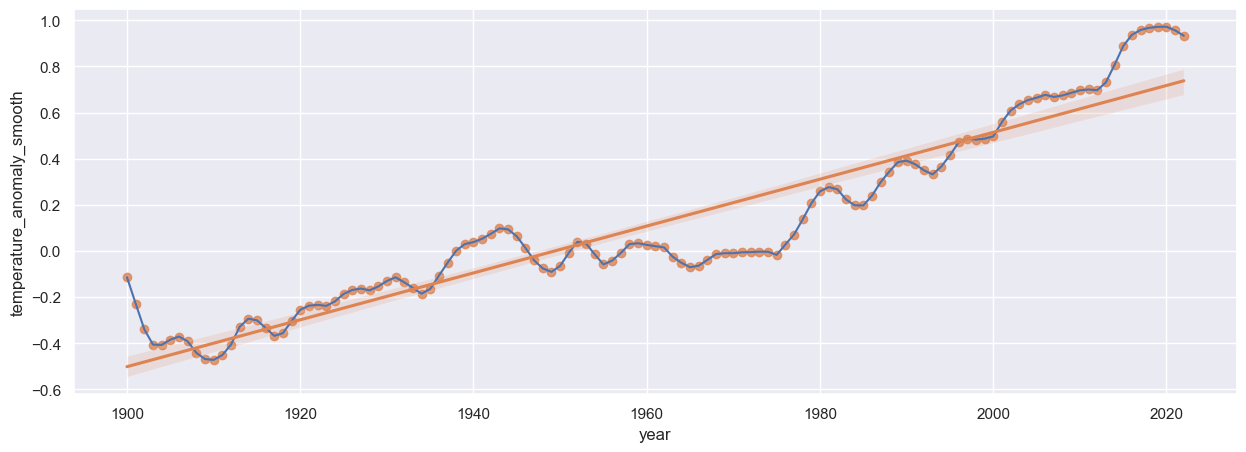

In [405]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly_smooth", data=temp_global)
sns.regplot(x="year", y="temperature_anomaly_smooth", data=temp_global);

When fitting a linear regression to the temperature anomaly data, the positive trend for the past 120 years becomes clearly visible.

## Regional temperature trend

We plot the smoothed temperature anomaly data for the regions Africa, Oceania, Americas, Asia and Europe.

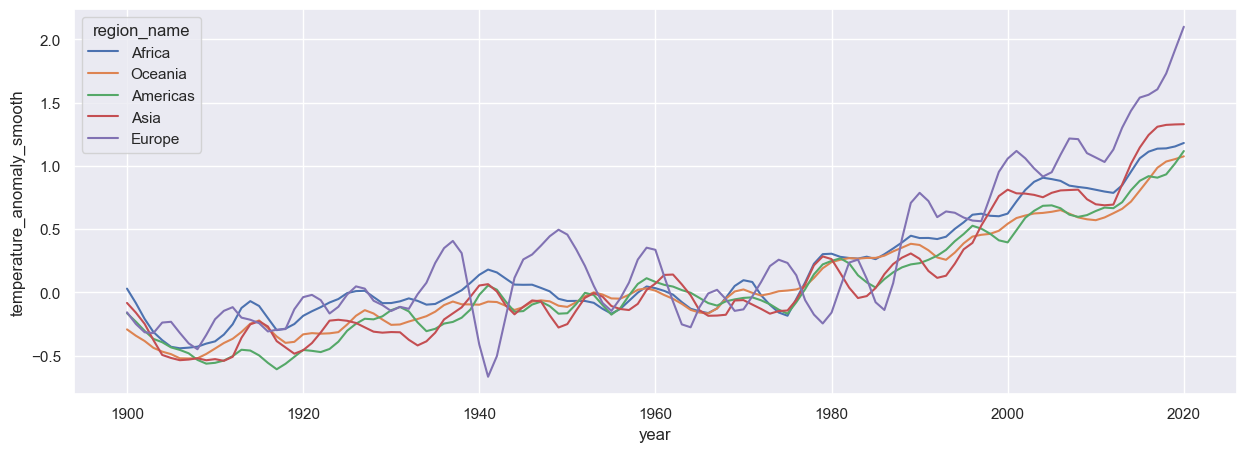

In [406]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly_smooth", hue="region_name", data=temp_region, ax=ax);

Again, we can see what seems to be a positive trend, with an especially stronger increase in the past 20 years. Europe seems to have the most extreme temperature anomalies and the strongest increase in the past 20 years.

## Did some countries have extremer temperature anomalies than others?

We try to detect which countries have the most extreme temperature anomalies in our dataset. We use three different approaches:

* Ranking countries based on their 2020 anomalies
* Ranking countries based on the slope parameter of a linear regression fitted to the anomalies
* Ranking countries by count of temperature anomaly outliers

### High anomaly in 2020

We sort countries based on their 2020 temperature anomaly values

In [407]:
temp_country[temp_country["year"] == 2020].sort_values(by=["temperature_anomaly_smooth"], ascending=False).head()

,year,country_code,temperature_anomaly,country_name,temperature_anomaly_smooth
27238,2020,LVA,3.315083,Latvia,3.265715
27186,2020,EST,3.403417,Estonia,3.244439
27276,2020,RUS,3.627500,Russia,3.186368
27236,2020,LTU,3.134333,Lithuania,3.181848
27157,2020,BLR,3.101917,Belarus,3.137251


In [408]:
temp_country[temp_country["year"] == 2020].sort_values(by=["temperature_anomaly_smooth"], ascending=False).tail()

,year,country_code,temperature_anomaly,country_name,temperature_anomaly_smooth
27279,2020,SDN,0.528083,Sudan,0.595429
27136,2020,AFG,0.379750,Afghanistan,0.549394
27263,2020,PAK,0.531750,Pakistan,0.492607
27210,2020,IND,0.430750,India,0.485394
27260,2020,NPL,0.323667,Nepal,0.366796


In [409]:
def plot_countries_temp_anomalies(temp_countries):
    fig, ax = plt.subplots(figsize=(15, 5))
    for i,country_code in enumerate(temp_countries):
        temp_selected_country = temp_country[temp_country["country_code"] == country_code]
        selected_country_name = temp_selected_country["country_name"].iloc[0]
        sns.lineplot(x="year",y="temperature_anomaly_smooth",data=temp_selected_country, ax=ax, label=selected_country_name)
    ax.legend();

### Linear regression

In [411]:
temp_regression_countries = []
for country_code in temp_country["country_code"].unique().tolist():
    result = smf.ols(formula="temperature_anomaly ~ year", data=temp_country[temp_country["country_code"] == country_code]).fit()
    temp_regression_countries.append([country_code,result.params["year"]])
temp_regression_countries = pd.DataFrame(temp_regression_countries)
temp_regression_countries.columns = ["country_code","year_slope"]
temp_regression_countries.sort_values(by=["year_slope"],ascending=False)

,country_code,year_slope
135,MNG,0.018051
228,ATA,0.017874
177,SJM,0.017829
106,KGZ,0.016326
104,KAZ,0.016276
...,...,...
185,STP,0.008036
41,COG,0.007833
93,IND,0.007577
129,MEX,0.007145


### Outlier count

We plot a boxplot to see if outliers exist in the temperature anomly data.

C:\Users\Sebi\anaconda3\envs\dopp-a2_3-9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='temperature_anomaly'>

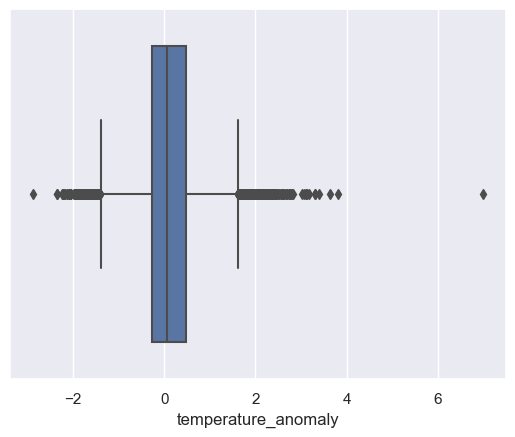

In [413]:
sns.boxplot(temp_country['temperature_anomaly'])

To determine at which value we can consider a temperature anomaly to be an outlier. We will calculate upper and lower bounds for temperature anomalies using the IQR and use these upper and lower bounds to determine outliers.

#### Calculate temperature anomaly IQR

In [414]:
temp_anomalies_np_arr = temp_country['temperature_anomaly'].to_numpy()
temp_anomalies_q3 = np.quantile(temp_anomalies_np_arr, 0.75)
temp_anomalies_q1 = np.quantile(temp_anomalies_np_arr, 0.25)
IQR = temp_anomalies_q3 - temp_anomalies_q1
IQR

0.7557916666666666

#### Calculate upper/lower bound for temp anomaly outliers using IQR

In [415]:
temp_anomaly_upper_bound = temp_anomalies_q3 + 1.5 * IQR
temp_anomaly_lower_bound = temp_anomalies_q1 - 1.5 * IQR
print(temp_anomaly_upper_bound)
print(temp_anomaly_lower_bound)

1.6220625
-1.4011041666666666


#### Detect extreme countries counting outliers based on IQR bounds

1. we filter for countries which include temperature anomaly outliers

2. we count the temperature anomaly outliers for each country and sort them by outlier count

In [416]:
temp_countries_anomaly_outlier = temp_country[(temp_country['temperature_anomaly'] >= temp_anomaly_upper_bound)
                                              | (temp_country['temperature_anomaly'] <= temp_anomaly_lower_bound)][['country_code', 'temperature_anomaly']]

temp_countries_anomaly_outlier = temp_countries_anomaly_outlier.groupby(['country_code']).count().sort_values(['temperature_anomaly'], ascending=False)
temp_countries_anomaly_outlier.head(5)

,temperature_anomaly
country_code,
SJM,32
FIN,29
EST,25
LVA,22
LTU,22


### Plotting extreme countries

With our three different approaches we found, that the following five countries are the most extreme for each approach:
* LVA, EST, RUS, LTU, BLR
* MNG, ATA, SJM, KGZ, KAZ
* SJM, FIN, EST, LVA, LTU

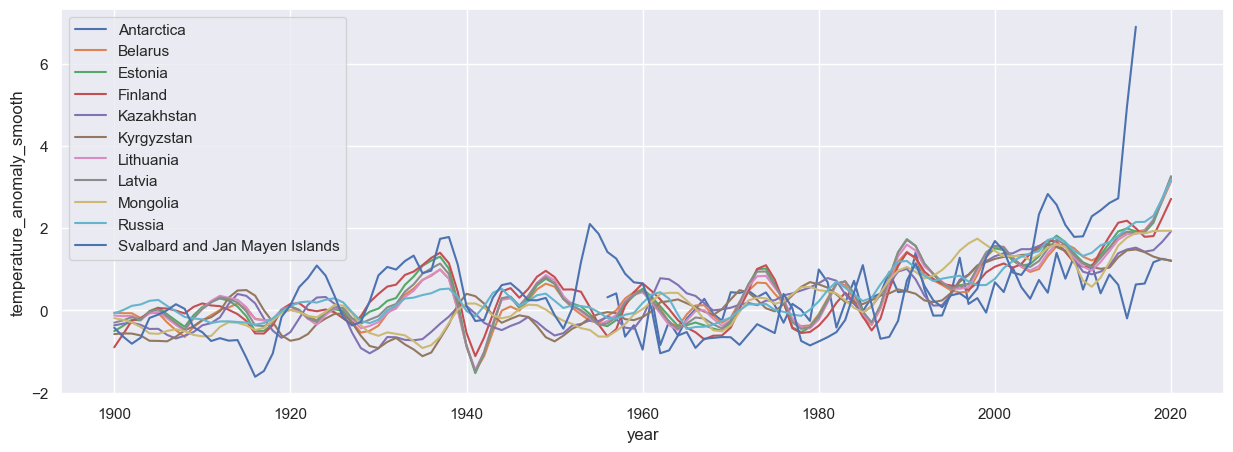

In [436]:
# Todo: decide which countries ultimately to plot
temp_extreme_countries =    ["LVA", "EST", "RUS", "LTU", "BLR",
                            "MNG", "ATA", "SJM", "KGZ", "KAZ",
                            "SJM", "FIN", "EST", "LVA", "LTU"]

temp_extreme_countries = np.unique(temp_extreme_countries)
plot_countries_temp_anomalies(temp_extreme_countries)

The Temperature anomalies of the most extreme countries (SJM, FIN, EST, LVA), based on our IQR outlier detection, are show in the plot above. We find that the temperature anomalies of the countries Finland, Estonia and Lativa, look similar which is probably due to their geographical closeness. The Svalbard and Jan Mayen Islands are located in the Arctic about midway between mainland Norway and the North Pole and show some extreme temperature anomalies, of up to 6 degrees after year 2000.

### Observation of a correlation between natural disasters and climate change

We are going to observe if a correlation between natural disasters and climate change exist. To do so we will create a new dataframe containing natural disaster deaths and temperature anomalies on a global level.

Filter for interesting disaster types

In [418]:
keep_types = ['Drought', 'Earthquake', 'Storm', 'Flood', 'Wildfire', 'Extreme temperature ']
dis_interesting_types = dis_all.loc[dis_all['type'].isin(keep_types),:]

#### Correlation of natural disaster deaths with temperature anomalies

Group deaths per disaster type per year to dis_global_deaths_yearly

In [419]:
dis_global_yearly_deaths = dis_interesting_types[['year', 'type', 'deaths']].groupby(['year', 'type']).agg('sum').reset_index()
dis_global_yearly_deaths_wide = pd.pivot(dis_global_yearly_deaths, index='year', columns='type', values='deaths')
dis_global_yearly_deaths_wide.head(3)

type,Drought,Earthquake,Extreme temperature,Flood,Storm,Wildfire
year,,,,,,
1900,1261000.0,140.0,NaN,300.0,6000.0,NaN
1901,NaN,18.0,NaN,NaN,NaN,NaN
1902,NaN,9148.0,NaN,NaN,600.0,NaN


We replace NaN values with 0, rename the columns by changing to lowercase, adding underscores instead of spaces and add _deaths as a suffix.

In [420]:
def reformatDisGlobalYearlyWide(dis_global_yearly_wide, suffix):
    dis_global_yearly_wide = dis_global_yearly_wide.fillna(0)
    dis_global_yearly_wide = dis_global_yearly_wide.astype('int32')
    dis_global_yearly_wide.columns = [c.replace(' ', '_').lower() for c in dis_global_yearly_wide.columns]
    dis_global_yearly_wide.rename(columns={'extreme_temperature_': 'extreme_temperature', 'mass_movement_(dry)': 'mass_movement_dry'}, inplace=True)
    dis_global_yearly_wide = dis_global_yearly_wide.add_suffix(suffix)
    dis_global_yearly_wide.reset_index(inplace=True)
    return dis_global_yearly_wide

In [421]:
dis_global_yearly_deaths_wide = reformatDisGlobalYearlyWide(dis_global_yearly_deaths_wide, "_deaths")

Add global temperature anomaly values

In [422]:
dis_global_yearly_deaths_wide['temperature_anomaly'] = temp_global['temperature_anomaly']
dis_global_yearly_deaths_wide['temperature_anomaly_smooth'] = temp_global['temperature_anomaly_smooth']
dis_global_yearly_deaths_wide.head(3)

,year,drought_deaths,earthquake_deaths,extreme_temperature_deaths,flood_deaths,storm_deaths,wildfire_deaths,temperature_anomaly,temperature_anomaly_smooth
0,1900,1261000,140,0,300,6000,0,-0.125167,-0.113891
1,1901,0,18,0,0,0,0,-0.199333,-0.227960
2,1902,0,9148,0,0,600,0,-0.362167,-0.339597


Plot correlations of temperature anomalies and total disaster deaths

In [423]:
def plotTempDisCorrelation(dis_temp_corr, temp_anomaly):
    corr = dis_temp_corr.drop('year', axis=1).corr(method='spearman')[[temp_anomaly]]
    corr.sort_values(by=temp_anomaly, inplace=True, ascending=False)
    corr = corr.T
    corr.drop(temp_anomaly, axis=1, inplace=True)
    cmap = sns.color_palette("rocket", as_cmap=True)
    fig, ax = plt.subplots(figsize=(12,1))
    sns.heatmap(corr,annot=True,vmin=0, vmax=1,cmap=cmap, annot_kws={"size": 8},ax=ax)
    ax.set_title("Correlation Matrix", y=1);
    return

We plot the correlation of temperature anomalies with the total deaths of the disaster types Drought, Earthquake, Storm, Flood, Wildfire and Extreme temperature.

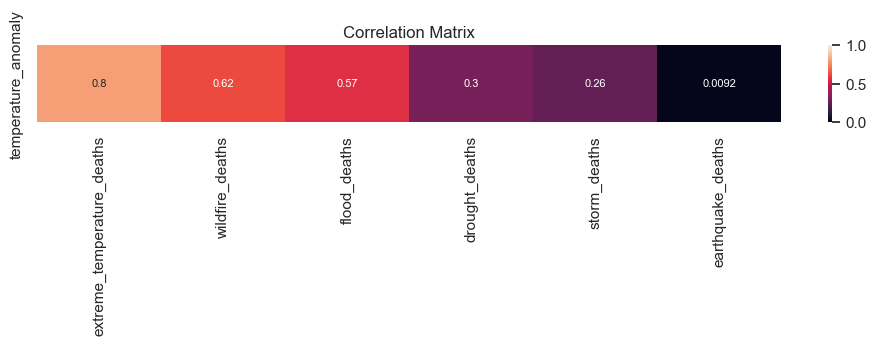

In [424]:
plotTempDisCorrelation(dis_global_yearly_deaths_wide.drop('temperature_anomaly_smooth', axis=1), 'temperature_anomaly')

We find that the correlation of disaster deaths with smoothed temperature anomaly values is almost identical with the raw temperature anomaly data.

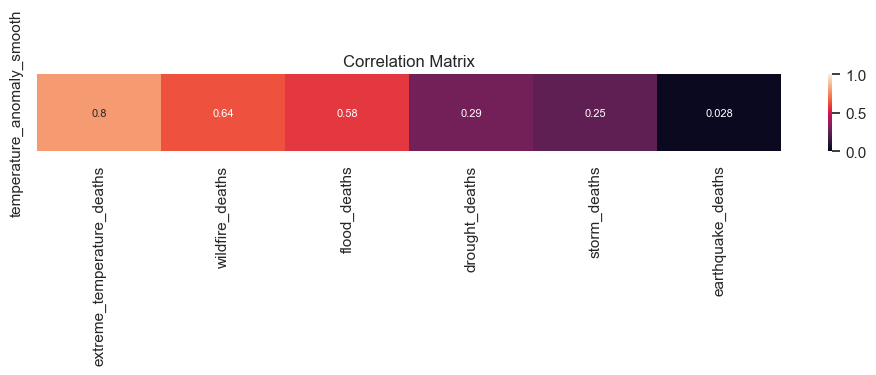

In [425]:
plotTempDisCorrelation(dis_global_yearly_deaths_wide.drop('temperature_anomaly', axis=1), 'temperature_anomaly_smooth')

##### Correlation of extreme temperature disasters with temperature

In [426]:
dis_type_extreme_temp = dis_all[dis_all['type'] == 'Extreme temperature ']
dis_type_extreme_temp = dis_type_extreme_temp[['year', 'subtype', 'deaths']].groupby(['year', 'subtype']).agg('sum').reset_index()
dis_type_extreme_temp_wide = pd.pivot(dis_type_extreme_temp, index='year', columns='subtype', values='deaths')
dis_type_extreme_temp_wide = reformatDisGlobalYearlyWide(dis_type_extreme_temp_wide, "_deaths")
dis_type_extreme_temp_wide = temp_global.merge(dis_type_extreme_temp_wide, how='left', on='year')
dis_type_extreme_temp_wide.fillna(0)

,year,temperature_anomaly,temperature_anomaly_smooth,cold_wave_deaths,heat_wave_deaths,severe_winter_conditions_deaths
0,1900,-0.125167,-0.113891,0.0,0.0,0.0
1,1901,-0.199333,-0.227960,0.0,0.0,0.0
2,1902,-0.362167,-0.339597,0.0,0.0,0.0
3,1903,-0.461750,-0.405825,0.0,0.0,0.0
4,1904,-0.519250,-0.407113,0.0,0.0,0.0
...,...,...,...,...,...,...
118,2018,0.879667,0.967451,337.0,378.0,0.0
119,2019,1.014750,0.971690,58.0,3012.0,0.0
120,2020,1.040083,0.971966,3.0,6340.0,0.0
121,2021,0.888083,0.956150,0.0,1044.0,0.0


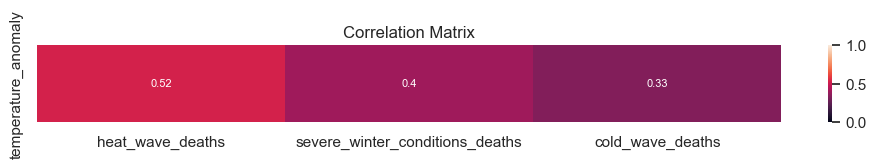

In [427]:
plotTempDisCorrelation(dis_type_extreme_temp_wide.drop('temperature_anomaly_smooth', axis=1), 'temperature_anomaly')

Plot correlation with smoothed temperature anomalies

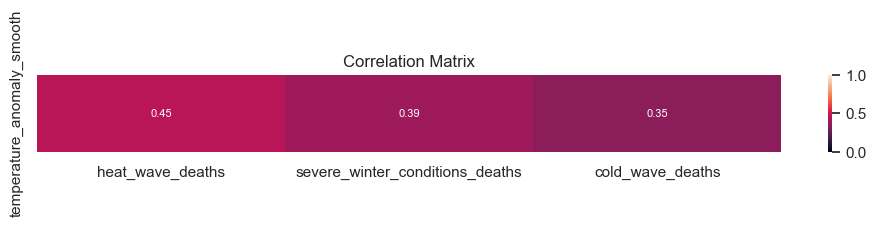

In [428]:
plotTempDisCorrelation(dis_type_extreme_temp_wide.drop('temperature_anomaly', axis=1), 'temperature_anomaly_smooth')

Now we also want to look at the correlation country wise.

Countries with a lot of relative heatwave deaths:


In [429]:
def returnDisSubtypeTempCountry(country_code, subtype):
    dis_interesting_countries = dis_all[(dis_all['country_code']==country_code) & (dis_all['subtype']==subtype)]
    dis_country_yearly_heat_deaths = dis_interesting_countries[['year', 'subtype', 'deaths']].groupby(['year', 'subtype']).agg('sum').reset_index()
    dis_country_yearly_heat_deaths['deaths'] = dis_country_yearly_heat_deaths.deaths.astype('int32')
    dis_country_yearly_heat_deaths = temp_country[temp_country['country_code']==country_code].merge(dis_country_yearly_heat_deaths)
    dis_country_yearly_heat_deaths.fillna(0)
    return dis_country_yearly_heat_deaths[['year', 'temperature_anomaly', 'temperature_anomaly_smooth', 'deaths']]

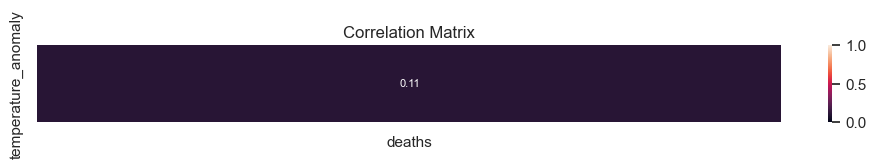

In [430]:
plotTempDisCorrelation(returnDisSubtypeTempCountry('FRA', 'Heat wave').drop('temperature_anomaly_smooth', axis=1), 'temperature_anomaly')

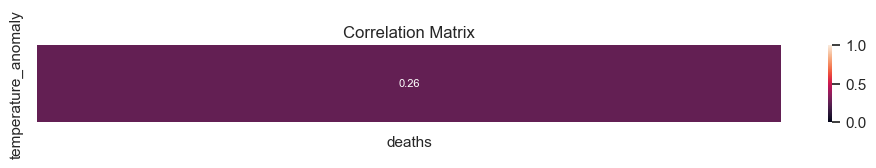

In [431]:
plotTempDisCorrelation(returnDisSubtypeTempCountry('ESP', 'Heat wave').drop('temperature_anomaly_smooth', axis=1), 'temperature_anomaly')

#### Correlation of natural disaster occurrences with temperature anomalies

Group disaster types and year and count occurrences

In [432]:
# Todo: maybe remove analysis by occurrence
dis_global_yearly_count = dis_interesting_types[['year', 'type']].groupby(['year', 'type']).size().reset_index()
dis_global_yearly_count.rename({0: 'occurrences'}, axis=1, inplace=True)
dis_global_yearly_count_wide = pd.pivot(dis_global_yearly_count, index='year', columns='type', values='occurrences')

Reformat column names and add _occurrences suffix to column names

In [433]:
dis_global_yearly_count_wide = reformatDisGlobalYearlyWide(dis_global_yearly_count_wide, "_occurrences")

Add global temperature anomaly values

In [434]:
dis_global_yearly_count_wide['temperature_anomaly'] = temp_global['temperature_anomaly']
dis_global_yearly_count_wide

,year,drought_occurrences,earthquake_occurrences,extreme_temperature_occurrences,flood_occurrences,storm_occurrences,wildfire_occurrences,temperature_anomaly
0,1900,2,1,0,1,1,0,-0.125167
1,1901,0,1,0,0,0,0,-0.199333
2,1902,0,4,0,0,1,0,-0.362167
3,1903,1,5,0,2,2,0,-0.461750
4,1904,0,3,0,0,1,0,-0.519250
...,...,...,...,...,...,...,...,...
118,2018,17,20,27,128,96,10,0.879667
119,2019,15,31,21,195,91,14,1.014750
120,2020,12,16,5,202,128,9,1.040083
121,2021,16,28,3,222,119,19,0.888083


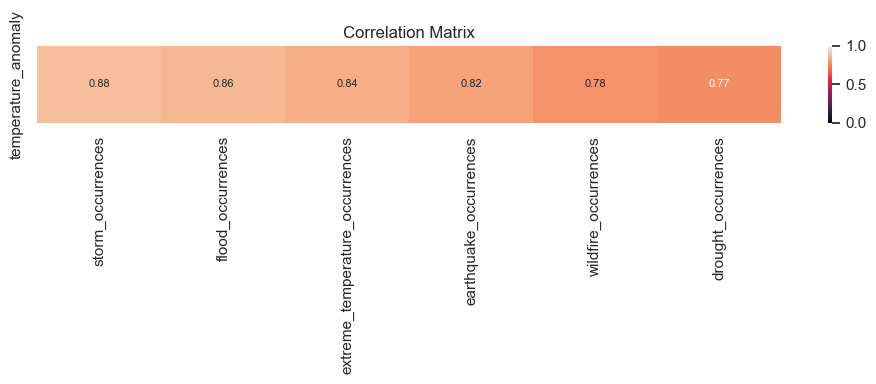

In [435]:
plotTempDisCorrelation(dis_global_yearly_count_wide, 'temperature_anomaly')